In [28]:
import numpy as np
import pandas as pd
import spacy
import csv
import json
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.distributions as tdist
from vocab import Vocab
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gc
from nltk import (sent_tokenize as splitter, wordpunct_tokenize as tokenizer)

In [29]:
device = torch.device('cuda')

In [30]:
with open('twitter_prep_data.json') as f:
    data = json.load(f)

In [31]:
dataset = pd.DataFrame.from_dict(data)

In [32]:
X_train, X_test = train_test_split(
    dataset, test_size=0.33, random_state=42)

In [33]:
class TwitterDataset(Dataset):
    def __init__(self, data, vocab):
        self.vocab = vocab
        self.data = data
        self.text = self.data['text'].values
        self.label = self.data['label'].values
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        
        text = self.text[index]
        label = self.label[index]
        text = self.vocab.sent2idx(text)
        #text = torch.LongTensor(text)
        
        sample = {'label': label, 'text': text}
        return sample
    
    def collate_fn(self, dicts): 
        pad_token = 0
        sents_padded = []
        corpus_size = len(dicts)
        len_text_list = [len(d['text']) for d in dicts]
        text_list = [d['text'] for d in dicts]
        labels = [i['label'] for i in dicts]

        sorted_len_text, sorted_text, sorted_labels = list(zip(*sorted(zip(len_text_list, text_list, labels), key=lambda x: x[0] ,reverse=True))) #sorts sentences in the reverse hierarchical order        
        max_lens = sorted_len_text[0]
        
        text_padded = [sorted_text[i] + [pad_token] * (max_lens - sorted_len_text[i]) for i in range(corpus_size)]
        text_padded = torch.LongTensor(text_padded)
        labels = torch.FloatTensor(sorted_labels)

        return text_padded, labels, sorted_len_text

In [34]:
def create_vocab(dataset):
    word_list = []
    for s in tqdm(dataset['text'].values):
         word_list += s
    
    word_counter = Counter(word_list)
    vocab = Vocab(word_counter, min_freq=10)
    
    return vocab

In [35]:
vocab = create_vocab(dataset)

100%|██████████| 226831/226831 [00:00<00:00, 2293846.75it/s]


In [27]:
type(vocab)

vocab.Vocab

In [10]:
train_dataset = TwitterDataset(X_train, vocab)
test_dataset = TwitterDataset(X_test, vocab)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=32,
                        shuffle=True, collate_fn=train_dataset.collate_fn)
val_dataloader = DataLoader(test_dataset, batch_size=32,
                           shuffle=False, collate_fn=test_dataset.collate_fn)

In [12]:
d = {}
with open('./fast_text.vec') as f:
    for i, line in enumerate(f.readlines()):
        word = line.split()[0]
        vector_string = line.split()[1:]
        d[word] = np.array(vector_string, dtype=np.float32)
        

In [13]:
matrix_len = len(vocab._token2idx)
weights_matrix = np.zeros((matrix_len, 100))
words_found = 0

for i, word in enumerate(vocab._token2idx):
    try: 
        weights_matrix[i] = d[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(100, ))

In [14]:
del d
gc.collect()

140

In [15]:
pretrained_embeddings = weights_matrix
pretrained_embeddings = torch.FloatTensor(pretrained_embeddings)
print(pretrained_embeddings.shape)

torch.Size([16226, 100])


In [16]:
# def create_emb_layer(weights_matrix, non_trainable=False):
#     print(len(weights_matrix))
#     num_embeddings, embedding_dim = weights_matrix.shape
#     emb_layer = nn.Embedding(num_embeddings, embedding_dim)
#     if non_trainable:
#         emb_layer.weight.requires_grad = False

#     return emb_layer, num_embeddings, embedding_dim

In [17]:
dataset[dataset['label']==1][:10]

,label,text
0,1,"[хоть, я, и, школота, , но, поверь, , у, нас, ..."
1,1,"[да, , все, , таки, он, немного, похож, на, не..."
10,1,"[люблю, маму, и, папу, , , а, в, остальное, я,..."
100,1,"[получается, , осторожно, котлетку, перекладыв..."
1000,1,"[дим, , ты, помогаешь, мне, , я, тебе, , все, ..."
10000,1,"[снова, еду, на, интенсив, , тренинг, ), впере..."
100000,1,"[всем, приятного, аппетита, , в, это, нелегкое..."
100001,1,"[спасибо, тем, , тип, меня, не, забывает, ), о..."
100002,1,"[тот, неловкий, момент, когда, ноутбук, дороже..."
100003,1,"[я, верен, всем, своим, девушкам, , , и, мы, в..."


In [18]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim,
                 hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [batch size, sent len, ]
        
        embedded = self.embedding(text)
        
        #embedded = [ batch size, sent len, emb dim]
        #pack sequence
        if text_lengths == 0:
            return
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        #output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        #hidden = self.dropout(
            
        hidden = torch.cat((hidden[-2,:,:], hidden[-1, :,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))

In [19]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = 0

model = RNN(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            0).to(device)

In [20]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.2542, -0.2078, -0.0741,  ..., -0.4683, -0.4614, -0.5700],
        [-0.2961, -0.5030,  1.0155,  ...,  0.7585, -0.0950, -0.3666],
        [-0.1321, -0.8479, -0.8618,  ..., -0.5184, -0.8642, -0.6379],
        ...,
        [ 0.2314, -0.0181, -0.4836,  ..., -0.2652, -0.8585, -1.0185],
        [ 0.2642, -0.2003, -0.1142,  ..., -0.3863,  0.0321, -0.3210],
        [ 0.3935,  0.9821, -0.1094,  ..., -0.1107,  0.0227, -0.6263]],
       device='cuda:0')

In [21]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [22]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [23]:
def train(model, iterator, optimizer, criterion):
    train_losses = []
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for batch_idx, (text, label, len_text) in enumerate(iterator):
        #text = torch.stack(text, -1)
        
        text = text.to(device)
        label = label.to(device)
        
        predictions = model(text, len_text).squeeze(1)

        loss = criterion(predictions, label.float())
        
        acc = binary_accuracy(predictions, label.float())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        train_losses.append(loss.item())
        
        if batch_idx % 50 == 0:
            plot(1, batch_idx, train_losses)
        
    return epoch_loss/len(iterator), epoch_acc / len(iterator)

In [24]:
def evaluate(model, iterator, criterion):
    eval_losses = []
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for text, label, len_text in iterator:
            text = text.to(device)
            label = label.to(device)
            predictions = model(text, len_text).squeeze(1)
            loss = criterion(predictions, label.float())
            eval_losses.append(loss.item())

            acc = binary_accuracy(predictions, label.float())
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc / len(iterator)

In [25]:
def plot(epoch, step, train_losses):
    clear_output()
    
    plt.title(f'Epochs {epoch}, step {step}')
    plt.plot(train_losses)
    plt.show()

In [26]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

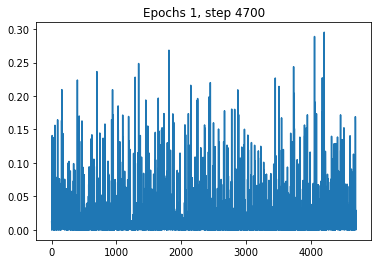

Epoch: 03 | Epoch Time: 1m 51s
	Train Loss: 0.014 | Train Acc: 99.51%
	 Val. Loss: 0.021 |  Val. Acc: 99.27%


In [27]:
N_EPOCHS = 3

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    torch.save(model.state_dict(),  'checkpoint.pth')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [28]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = 0

model = RNN(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            0).to(device)

In [29]:
model.load_state_dict(torch.load('checkpoint.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [30]:
model.eval()

RNN(
  (embedding): Embedding(16226, 100, padding_idx=0)
  (rnn): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)

In [69]:
sentence = 'Какой замечательный день!:)))'

In [70]:
tokenized = [tokenizer(sentence) for sentence in splitter(sentence)]
indexed = [vocab.sent2idx(tokenized[0])]
length = [len(indexed[0])]
tensor = torch.LongTensor(indexed).to(device)
prediction = torch.sigmoid(model(tensor, length))

In [71]:
length

[4]

In [73]:
prediction.item()

0.047595903277397156

In [34]:
class SentimentPredictor(object):
    def __init__(self):
        self.model, self.vocab = model, vocab
        
    def predict_sentiment(self, sentence):
        self.model.eval()
        tokenized = [tokenizer(sentence) for sentence in splitter(sentence)]
        indexed = [self.vocab.sent2idx(tokenized[0])]
        length = [len(indexed)]
        tensor = torch.LongTensor(indexed).to(device)
        prediction = torch.sigmoid(self.model(tensor, length))
        
        return prediction.item()

In [35]:
s = SentimentPredictor()

In [36]:
score = s.predict_sentiment('Какой сегодня хороший день!:)')

In [37]:
score

0.21836453676223755

In [38]:
score1 = s.predict_sentiment('Сегодня очень грустный день:((')

In [39]:
score1

0.21836453676223755